<a href="https://colab.research.google.com/github/logansmith9454/cse450/blob/main/notebooks/starter_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install scikit-learn==1.5.2

In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt


housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')

cat_cols = ['waterfront', 'view', 'condition', 'grade', 'zipcode']
num_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
          'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
          'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sale_year', 'sale_month']

def transform_data(df, train_cols=None):
  # Add sale_year and sale_month columns
  df['sale_year'] = pd.to_datetime(df['date']).dt.year
  df['sale_month'] = pd.to_datetime(df['date']).dt.month

  df = df.drop(['date'], axis=1)

  if 'price' in df.columns:
      X = pd.get_dummies(df.drop('price', axis=1), columns=cat_cols)
      y = df['price']
  else:
      X = pd.get_dummies(df, columns=cat_cols)
      y = None

  if train_cols is not None:
      X = X.reindex(columns=train_cols, fill_value=0)


  return X, y, X.columns.tolist()


X, y, train_cols = transform_data(housing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = xgb.XGBRegressor(enable_categorical=True, colsample_bytree=0.4, learning_rate=0.09, max_depth=4, n_estimators=800, subsample=0.8)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: ${rmse:,.2f}")
print(f"R^2: {r2:.1%}")

RMSE: $125,573.51
R^2: 88.6%


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error

# Define expanded parameter grid for XGBoost
param_grid = {
    'n_estimators': [750, 800],
    'learning_rate': [0.08, 0.09],
    'max_depth': [3, 4],
    'subsample': [0.7, 0.8], #0.6
    'colsample_bytree': [0.4, 0.5]
}

# Create GridSearchCV
grid_search = GridSearchCV(
    estimator=model,  # Your existing pipeline
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='r2',  # Optimize for R-squared
    n_jobs=-1  # Use all CPU cores
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Print best parameters
print(f'Best Parameters: {grid_search.best_params_}')

Best Parameters: {'colsample_bytree': 0.4, 'learning_rate': 0.09, 'max_depth': 4, 'n_estimators': 800, 'subsample': 0.8}


In [3]:
# Calculate the correlation matrix
correlation_matrix = housing.corr(numeric_only=True)

# Get the correlations with the 'price' column
price_correlations = correlation_matrix['price'].sort_values(ascending=False)

# Display the correlations
print("Correlation with Price:")
print(price_correlations)

Correlation with Price:
price            1.000000
sqft_living      0.703920
grade            0.666447
sqft_above       0.607082
sqft_living15    0.585374
bathrooms        0.527989
view             0.395961
sqft_basement    0.325183
lat              0.307516
bedrooms         0.307281
waterfront       0.260133
floors           0.254428
yr_renovated     0.121534
sqft_lot         0.090317
sqft_lot15       0.082413
yr_built         0.054187
condition        0.035146
long             0.023976
sale_year        0.007080
sale_month      -0.012920
id              -0.016081
zipcode         -0.055857
Name: price, dtype: float64


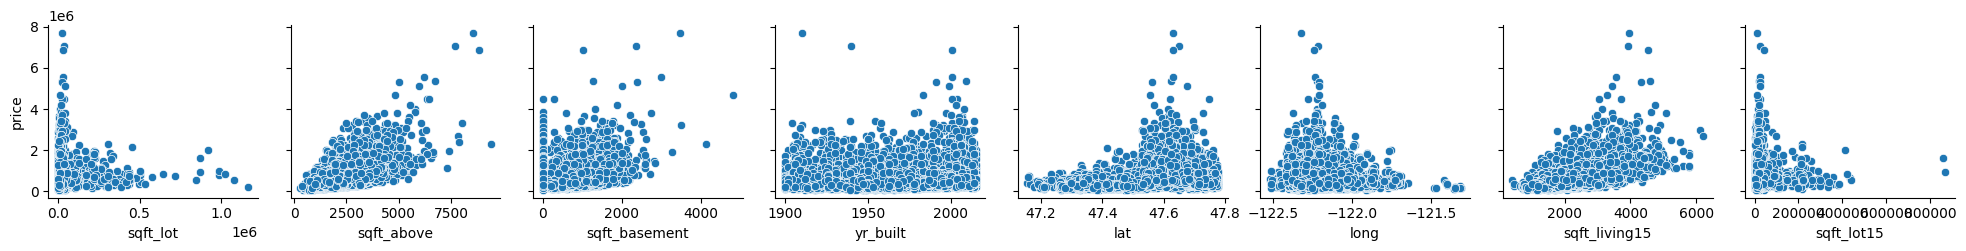

In [4]:
cont_cols = ["sqft_lot", "sqft_above", "sqft_basement", "yr_built", "lat", "long", "sqft_living15", "sqft_lot15"]
sns.pairplot(data = housing, x_vars = cont_cols, y_vars = 'price')

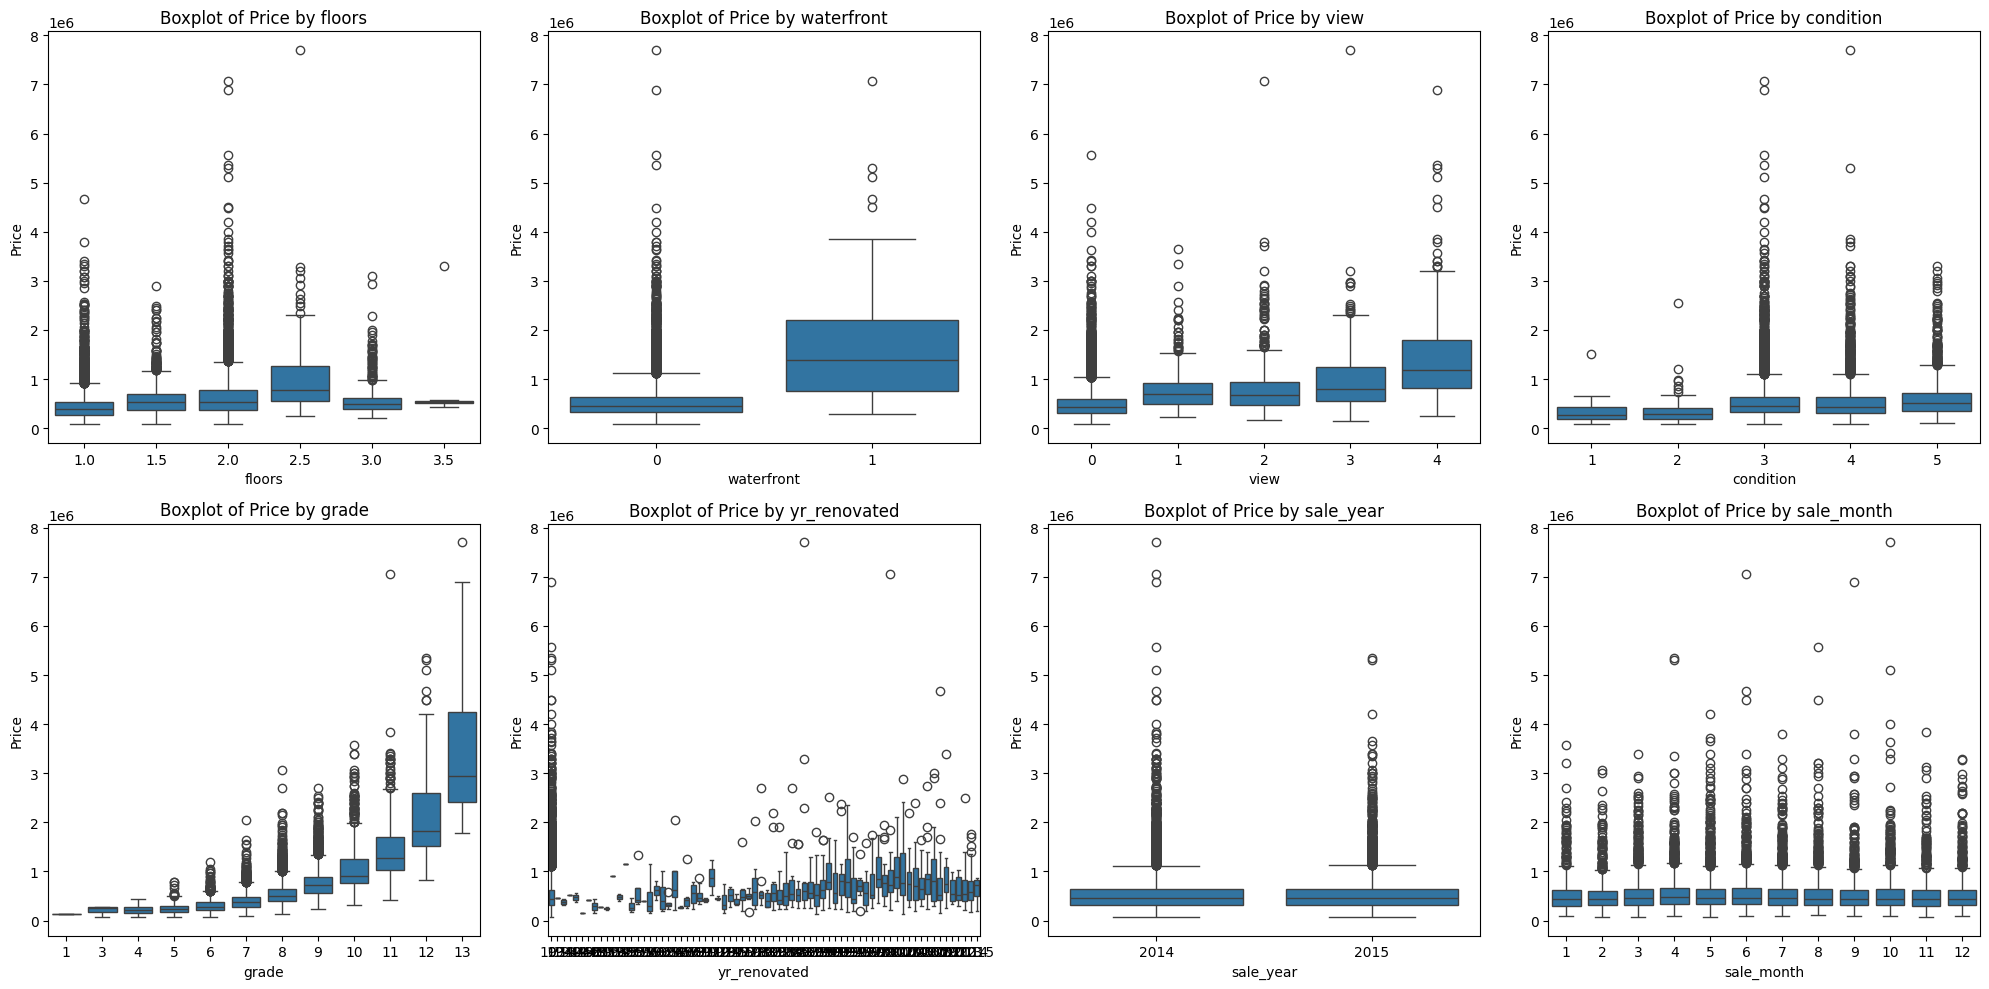

In [5]:
# Columns that are more discrete or categorical
cont_cols = ["floors", "waterfront", "view", "condition", "grade", "yr_renovated", "sale_year", "sale_month"]

# Create individual boxplots for each discrete column against price with independent y-axes
n_cols = 4 # Number of columns for the grid
n_rows = (len(cont_cols) + n_cols - 1) // n_cols # Calculate number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5)) # Adjust figure size as needed
axes = axes.flatten() # Flatten the axes array for easier iteration

for i, col in enumerate(cont_cols):
    sns.boxplot(data=housing, x=col, y='price', ax=axes[i])
    axes[i].set_title(f'Boxplot of Price by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Price')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

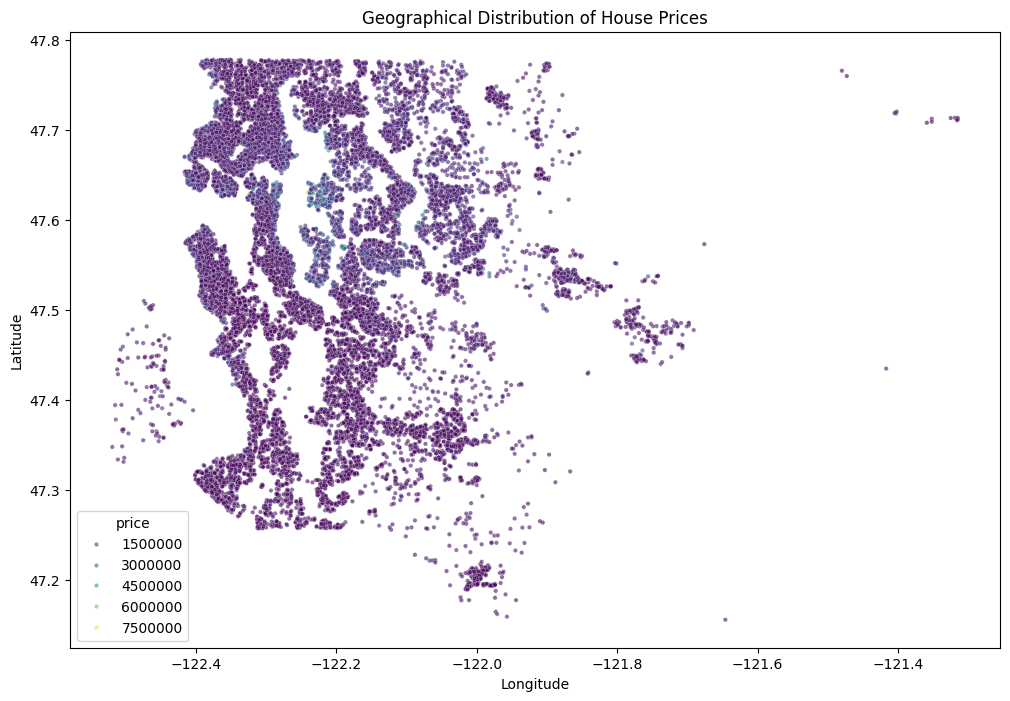

In [6]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=housing, x='long', y='lat', hue='price', palette='viridis', alpha=0.6, s=10)
plt.title('Geographical Distribution of House Prices')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [30]:
mini_holdout = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini.csv')

mini_X, _, _ = transform_data(mini_holdout, train_cols=train_cols) # Get only the features, y will be None

mini_y_pred = model.predict(mini_X)

# Create a DataFrame with the predictions
predictions_df = pd.DataFrame(mini_y_pred, columns=['price'])

# Save the DataFrame to a CSV file
# file_name = 'v2-team1-module3-predictions.csv'
# predictions_df.to_csv(file_name, index=False)
# files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

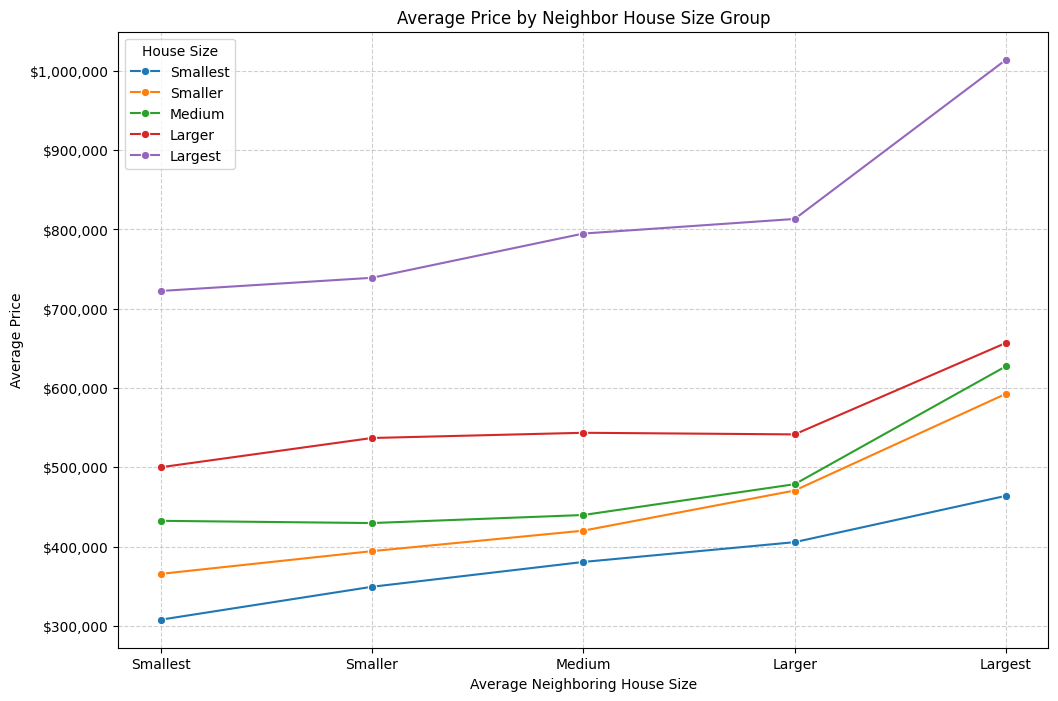

In [34]:
# The average_price_by_bins DataFrame is already calculated in the previous cell
# It has sqft_living_bin as index and sqft_living15_bin as columns

# We need to reshape the DataFrame for line plotting
average_price_for_line_plot = average_price_by_bins.stack().reset_index(name='average_price')
average_price_for_line_plot.rename(columns={'level_0': 'sqft_living_bin', 'level_1': 'sqft_living15_bin'}, inplace=True)

# Create more user-friendly labels for the bins
bin_labels = ['Smallest', 'Smaller', 'Medium', 'Larger', 'Largest'] # Simplified labels
average_price_for_line_plot['House Size'] = average_price_for_line_plot['sqft_living_bin'].map(lambda x: bin_labels[x])
average_price_for_line_plot['sqft_living15_bin_label'] = average_price_for_line_plot['sqft_living15_bin'].map(lambda x: bin_labels[x])

plt.figure(figsize=(12, 8))
sns.lineplot(data=average_price_for_line_plot, x='sqft_living15_bin_label', y='average_price', hue='House Size', marker='o')
plt.title('Average Price by Neighbor House Size Group')
plt.xlabel('Average Neighboring House Size')
plt.ylabel('Average Price')
# plt.xticks(average_price_for_line_plot['sqft_living15_bin_label'].unique()) # Ensure all x-ticks are shown
plt.grid(True, linestyle='--', alpha=0.6)

# Format y-axis labels as currency
import matplotlib.ticker as mtick
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.show()

In [35]:
print("Average Price by House Size Group and Neighbor House Size Group:")
display(average_price_for_line_plot)

Average Price by House Size Group and Neighbor House Size Group:


,sqft_living_bin,sqft_living15_bin,average_price,House Size,sqft_living15_bin_label
0,0,0,3.076412e+05,Smallest,Smallest
1,0,1,3.491975e+05,Smallest,Smaller
2,0,2,3.805194e+05,Smallest,Medium
3,0,3,4.054888e+05,Smallest,Larger
4,0,4,4.639616e+05,Smallest,Largest
5,1,0,3.654662e+05,Smaller,Smallest
6,1,1,3.941531e+05,Smaller,Smaller
7,1,2,4.199917e+05,Smaller,Medium
8,1,3,4.706471e+05,Smaller,Larger
9,1,4,5.926858e+05,Smaller,Largest


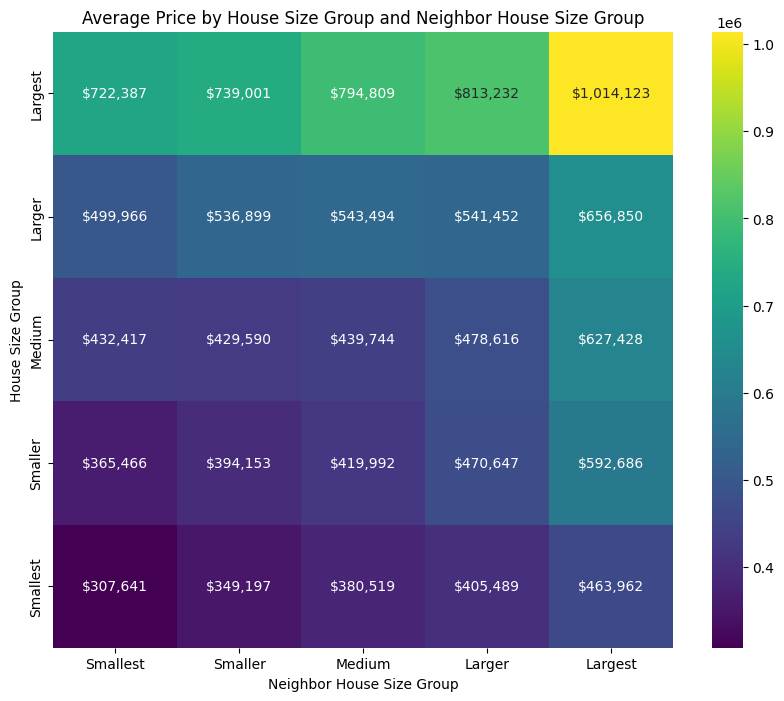

In [30]:
# Define the number of bins
n_bins = 5

# Create bins for sqft_living and sqft_living15
housing['sqft_living_bin'] = pd.qcut(housing['sqft_living'], q=n_bins, labels=False, duplicates='drop')
housing['sqft_living15_bin'] = pd.qcut(housing['sqft_living15'], q=n_bins, labels=False, duplicates='drop')

# Create more user-friendly labels for the bins
bin_labels = ['Smallest', 'Smaller', 'Medium', 'Larger', 'Largest'] # Simplified labels
# Map numerical bins to user-friendly labels for plotting
average_price_by_bins_labeled = average_price_by_bins.copy()
average_price_by_bins_labeled.index = average_price_by_bins_labeled.index.map(lambda x: bin_labels[x])
average_price_by_bins_labeled.columns = average_price_by_bins_labeled.columns.map(lambda x: bin_labels[x])


# Group by the bins and calculate the average price
average_price_by_bins = housing.groupby(['sqft_living_bin', 'sqft_living15_bin'])['price'].mean().unstack()

# Create a heatmap of the average price by bins
plt.figure(figsize=(10, 8))
ax = sns.heatmap(average_price_by_bins_labeled, annot=True, fmt=".0f", cmap='viridis')
plt.title('Average Price by House Size Group and Neighbor House Size Group')
plt.xlabel('Neighbor House Size Group')
plt.ylabel('House Size Group')

# Invert the y-axis
ax.invert_yaxis()

# Format heatmap annotations as currency
for t in ax.texts:
    t.set_text('${:,.0f}'.format(float(t.get_text())))

plt.show()

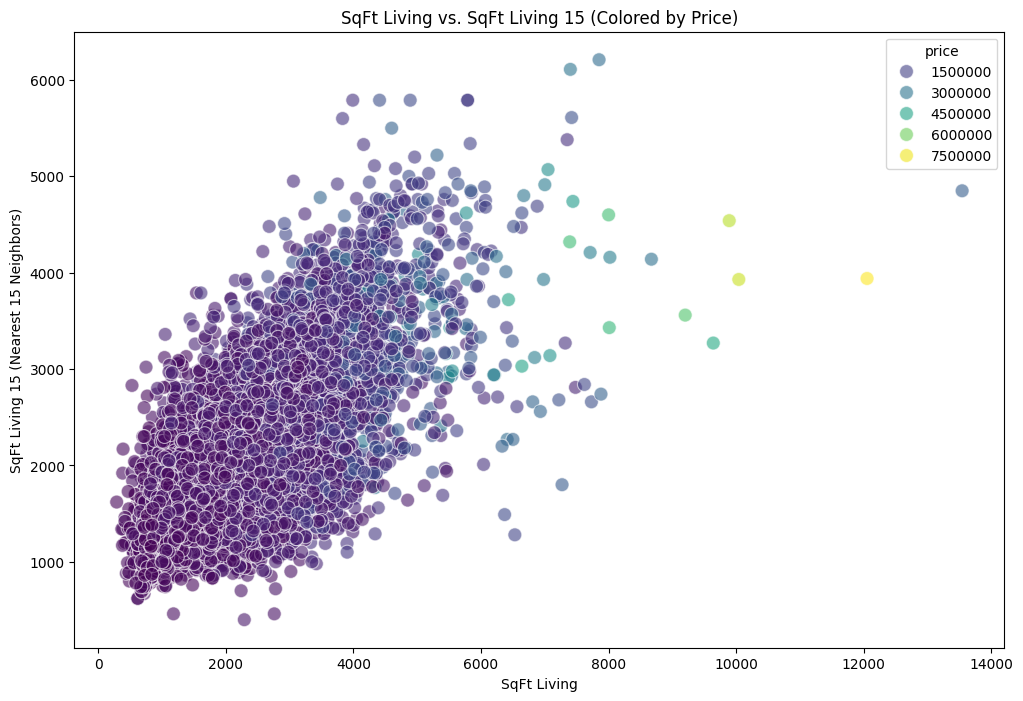

In [19]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=housing, x='sqft_living', y='sqft_living15', hue='price', palette='viridis', alpha=0.6, s=100)
plt.title('SqFt Living vs. SqFt Living 15 (Colored by Price)')
plt.xlabel('SqFt Living')
plt.ylabel('SqFt Living 15 (Nearest 15 Neighbors)')
plt.show()

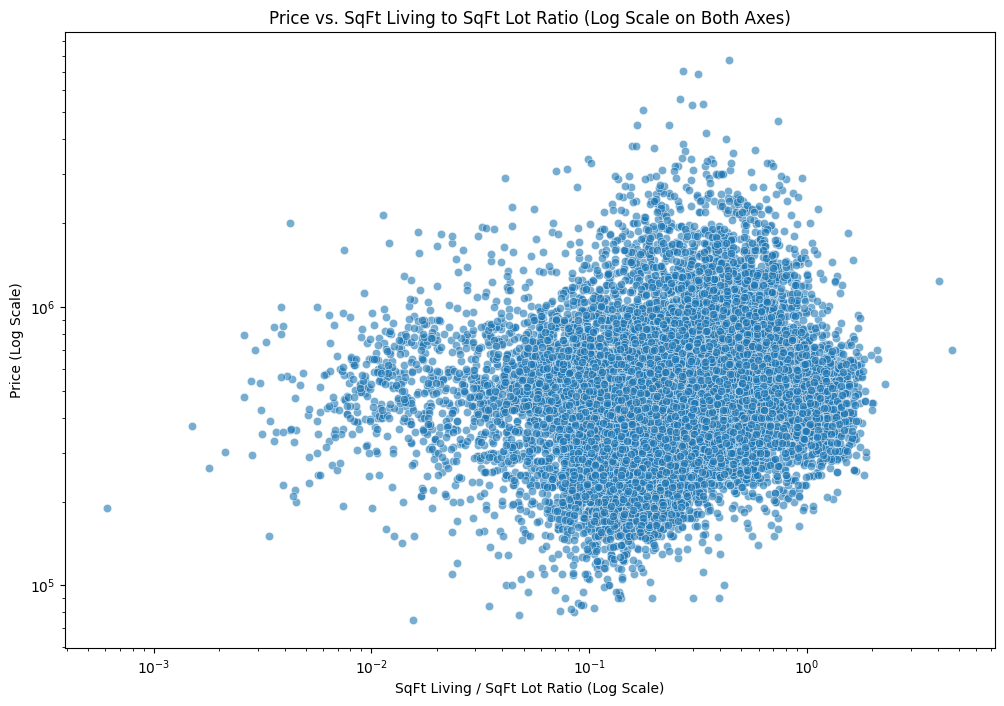

In [9]:
# Create the new feature: ratio of sqft_living to sqft_lot
# Add a small epsilon to avoid division by zero
housing['sqft_living_lot_ratio'] = housing['sqft_living'] / (housing['sqft_lot'] + 1e-6)

# Create a scatter plot of the new feature against price
plt.figure(figsize=(12, 8))
sns.scatterplot(data=housing, x='sqft_living_lot_ratio', y='price', alpha=0.6)
plt.xscale('log') # Apply logarithmic scale to the x-axis
plt.yscale('log') # Apply logarithmic scale to the y-axis
plt.title('Price vs. SqFt Living to SqFt Lot Ratio (Log Scale on Both Axes)')
plt.xlabel('SqFt Living / SqFt Lot Ratio (Log Scale)')
plt.ylabel('Price (Log Scale)')
plt.show()

In [ ]:
holdout = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test.csv')

X, _, _ = transform_data(holdout, train_cols=train_cols)

y_pred = model.predict(X)

predictions_df = pd.DataFrame(y_pred, columns=['price'])

print(f"{len(holdout)=}")
print(f"{len(predictions_df)=}")

# Save the DataFrame to a CSV file
# file_name = 'v2-team1-module3-predictions.csv'
# predictions_df.to_csv(file_name, index=False)
# files.download(file_name)

In [15]:
# Create 'house_age' feature
housing['house_age'] = housing['sale_year'] - housing['yr_built']

# Create 'time_since_renovation' feature
# If yr_renovated is 0, assume no renovation and set time since renovation to 0
housing['time_since_renovation'] = housing.apply(lambda row: row['sale_year'] - row['yr_renovated'] if row['yr_renovated'] != 0 else 0, axis=1)

print("New features created: 'house_age' and 'time_since_renovation'")
display(housing[['sale_year', 'yr_built', 'yr_renovated', 'house_age', 'time_since_renovation']].head())

New features created: 'house_age' and 'time_since_renovation'


,sale_year,yr_built,yr_renovated,house_age,time_since_renovation
0,2014,2007,0,7,0
1,2015,1979,0,36,0
2,2014,1914,0,100,0
3,2014,1985,0,29,0
4,2014,1947,0,67,0


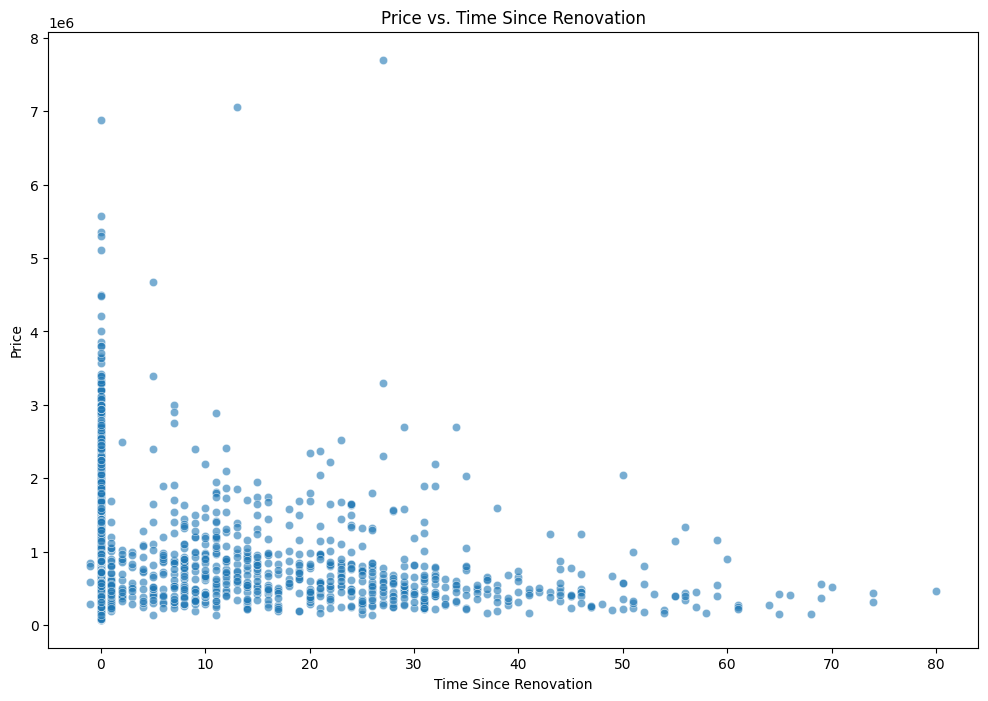

In [17]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=housing, x='time_since_renovation', y='price', alpha=0.6)
plt.title('Price vs. Time Since Renovation')
plt.xlabel('Time Since Renovation')
plt.ylabel('Price')
plt.show()